## Individual Training - Baseline
Training different models on v2 and abs with common labels

In [1]:
import os
os.chdir('/workspace')

from trainer import *

cfg = {
    'n_classes': 10,
    'v2_samples_per_answer': 300,
    'abs_samples_per_answer': 150,
    
    'image_encoder': 'facebook/dinov2-base',
    'text_encoder': 'bert-base-uncased',

    'relaxation_period': 3,  # epochs to wait where accuracy is dropping 
                             # below moving average before ending the run
    
    'batch_size': 250,
    'epochs': 20,
    'base_lr': 0.001,
    'weight_decay': 5e-4,

    'fusion_mode': 'cat',
    'num_stacked_attn': 1,

    'weights_save_root': './weights/raw'
}

if False:
    trainer_v2(cfg, 'v2', vqa_v2, vqa_abs, show_plot=True)
    trainer_v2(cfg, 'abs', vqa_v2, vqa_abs, show_plot=True)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg['v2_ckpt'] = 'weights/selected/*v2_10-classes_3000-total-samples_0.001-lr_1-stacked_attn_cat-fusion-mode_8-attn_heads_strict-accuracy.pth'
cfg['abs_ckpt'] = 'weights/selected/*abs_10-classes_1500-total-samples_0.001-lr_1-stacked_attn_cat-fusion-mode_8-attn_heads_strict-accuracy.pth'

## Evaluating

In [3]:
(v2_train_data, v2_val_data), (abs_train_data, abs_val_data), labels = data_processing_v2(cfg, vqa_v2, vqa_abs)
model = VLModel(cfg, return_embeddings=True).cuda()

def eval_domain_adaptation(eval_dataset, model_ckpt, evaluate_train=False):
    if eval_dataset == 'v2':
        train_data, val_data = v2_train_data, v2_val_data
    elif eval_dataset == 'abs':
        train_data, val_data = abs_train_data, abs_val_data

    train_dataset = VQADataset(cfg, train_data)
    val_dataset = VQADataset(cfg, val_data)

    train_dataloader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=cfg['batch_size'], shuffle=True)

    if model_ckpt == 'v2':
        ckpt = cfg['v2_ckpt']
    elif model_ckpt == 'abs':
        ckpt = cfg['abs_ckpt']

    state_dict = torch.load(ckpt, weights_only=True)
    model.load_state_dict(state_dict)

    dataloader = val_dataloader if not evaluate_train else train_dataloader

    model.eval()
    correct, total = 0, 0
    embeddings = None

    with torch.no_grad():
        for i_tokens, q_tokens, label in dataloader:
            i_tokens = {key: value.cuda() for key, value in i_tokens.items()}
            q_tokens = {key: value.cuda() for key, value in q_tokens.items()}
            label = label.cuda()
            
            logits, embedding = model(i_tokens, q_tokens)
            embeddings = np.concatenate((embeddings, embedding), axis=0) if embeddings is not None else embedding

            # Compute accuracy
            _, predicted_indices = torch.max(logits, dim=1)
            label_indices = torch.argmax(label, dim=1)
            is_correct = (predicted_indices == label_indices)

            total += label.shape[0]
            correct += is_correct.sum().item()

    accuracy = (correct / total)

    source = 'v2 ' if model_ckpt == 'v2' else 'abs'
    target = 'v2 ' if eval_dataset == 'v2' else 'abs'
    split = 'train set' if evaluate_train else 'val set  '
    print(f'{source} -> {target} | {split} \t accuracy = {accuracy*100:.2f}%')
    
    return embeddings

Number of Common Labels = 25
Labels: ['man', 'yes', 'no', 'brown', 'dog', '2', '1', 'gray', '3', 'food']
V2: 	Train size = 2400           | Val size = 600 | Total = 3000
Abs: 	Train size = 1200           | Val size = 300 | Total = 1500
--------------------


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
# v2 -> v2
v2_val_embeddings = eval_domain_adaptation(model_ckpt='v2', eval_dataset='v2', evaluate_train=False)
v2_train_embeddings = eval_domain_adaptation(model_ckpt='v2', eval_dataset='v2', evaluate_train=True)

# abs -> abs
abs_val_embeddings = eval_domain_adaptation(model_ckpt='abs', eval_dataset='abs', evaluate_train=False)
abs_train_embeddings = eval_domain_adaptation(model_ckpt='abs', eval_dataset='abs', evaluate_train=True)

v2  -> v2  | val set   	 accuracy = 57.67%
v2  -> v2  | train set 	 accuracy = 64.12%
abs -> abs | val set   	 accuracy = 62.33%
abs -> abs | train set 	 accuracy = 71.25%


In [5]:
# v2 -> abs
v2_abs_val_embeddings = eval_domain_adaptation(model_ckpt='v2', eval_dataset='abs', evaluate_train=False)
v2_abs_train_embeddings = eval_domain_adaptation(model_ckpt='v2', eval_dataset='abs', evaluate_train=True)

# abs -> v2
abs_v2_val_embeddings = eval_domain_adaptation(model_ckpt='abs', eval_dataset='v2', evaluate_train=False)
abs_v2_train_embeddings = eval_domain_adaptation(model_ckpt='abs', eval_dataset='v2', evaluate_train=True)

v2  -> abs | val set   	 accuracy = 48.00%
v2  -> abs | train set 	 accuracy = 49.08%
abs -> v2  | val set   	 accuracy = 45.17%
abs -> v2  | train set 	 accuracy = 47.88%


## Visualizing embeddings

In [6]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

def plot_tsne(embeddings, plot_labels, perplexities, title=''):
    n_plots = len(perplexities)
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6))
    
    for idx, perplexity in enumerate(perplexities):
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_embeddings = tsne.fit_transform(embeddings)
        
        colors = {'vv': 'blue', 'aa': 'red', 'va': 'orange', 'av': 'violet'}
        ax = axes[idx]
        for i, plot_label in enumerate(plot_labels):
                
            ax.scatter(tsne_embeddings[i, 0], tsne_embeddings[i, 1], color=colors[plot_label])
            ax.text(tsne_embeddings[i, 0] + 0.1, tsne_embeddings[i, 1], '', fontsize=9)
        
        ax.set_title(f'Perplexity = {perplexity}')
    
    custom_legend = [mpatches.Patch(color=colors[label], label=label) for label in set(plot_labels)]
    fig.legend(handles=custom_legend)
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

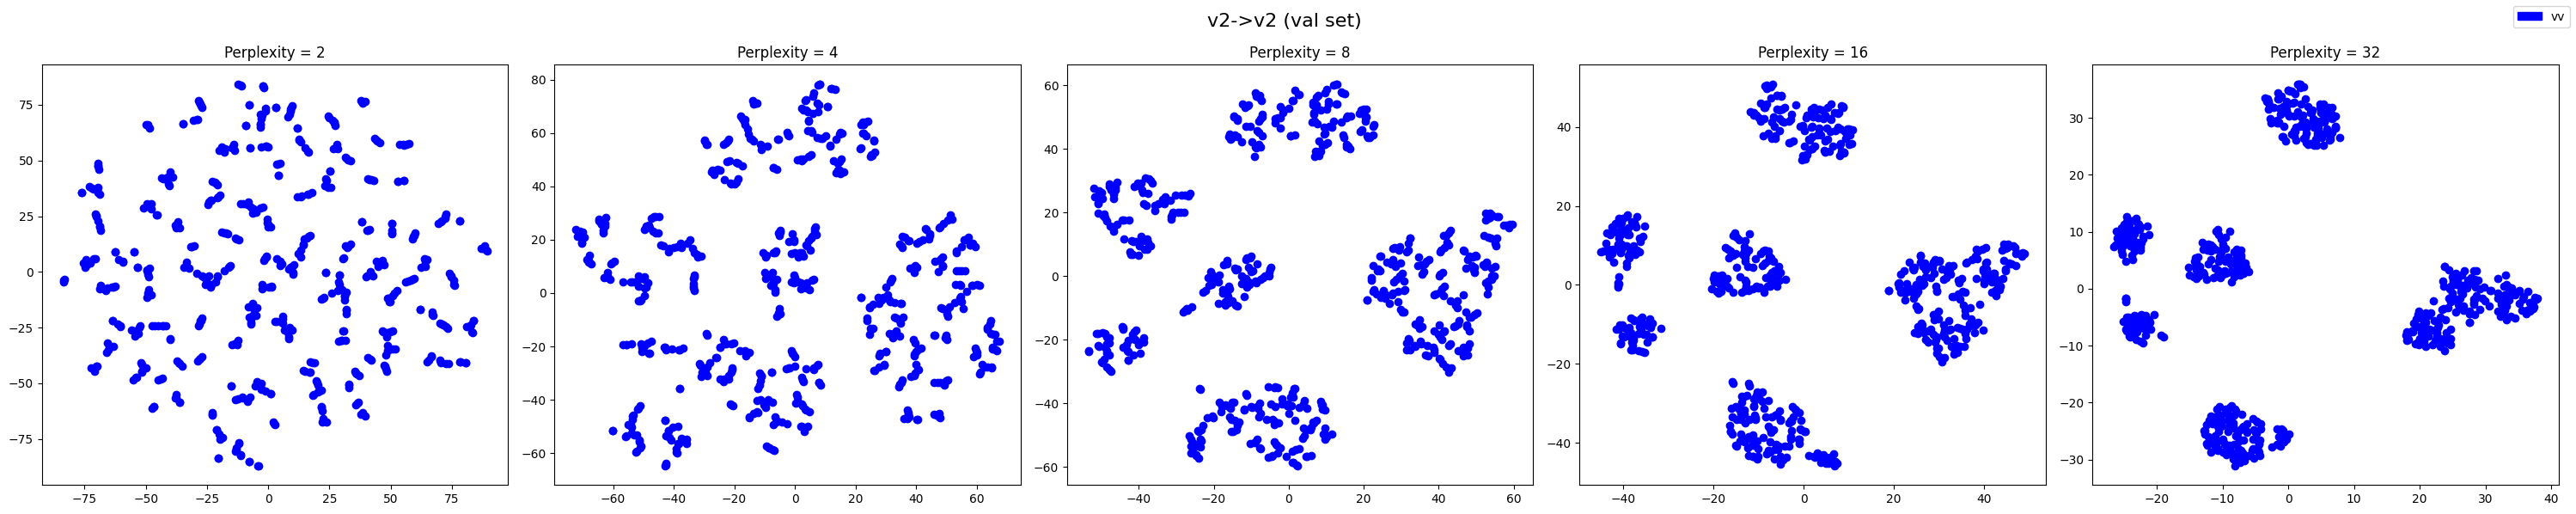

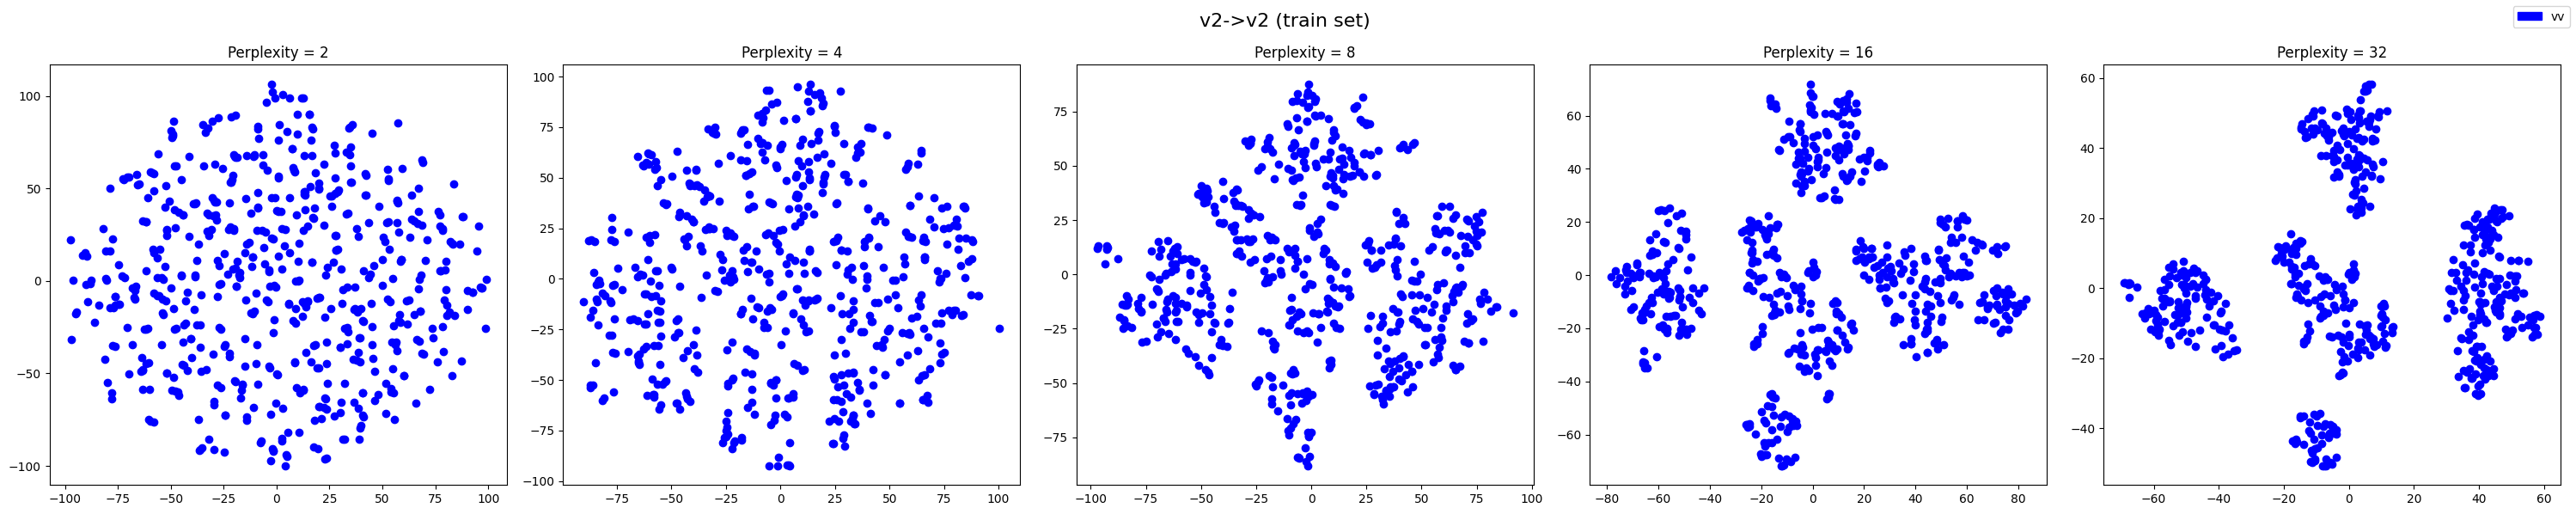

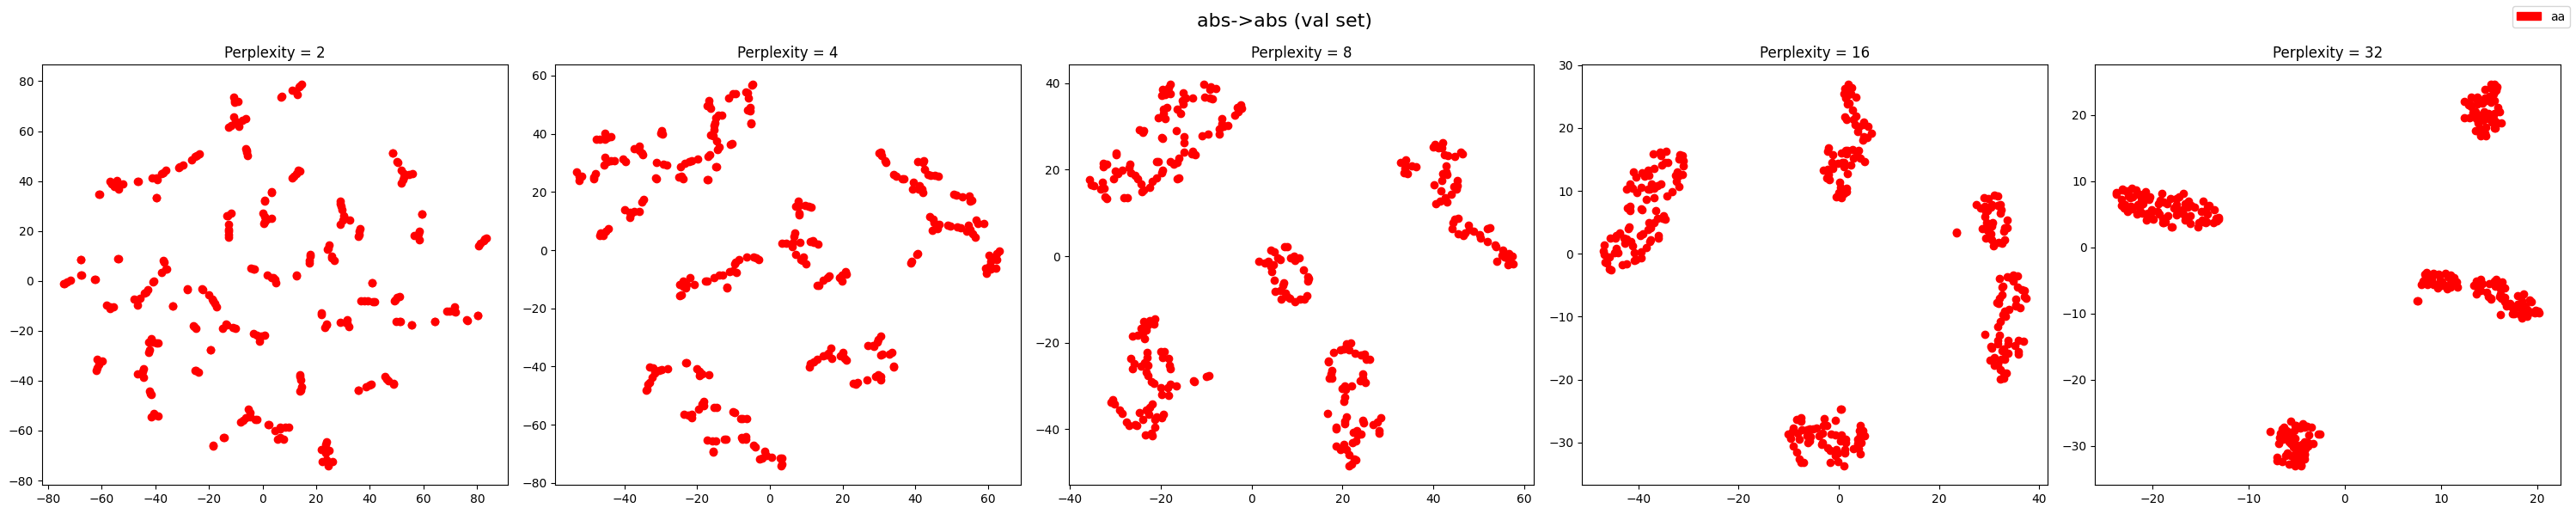

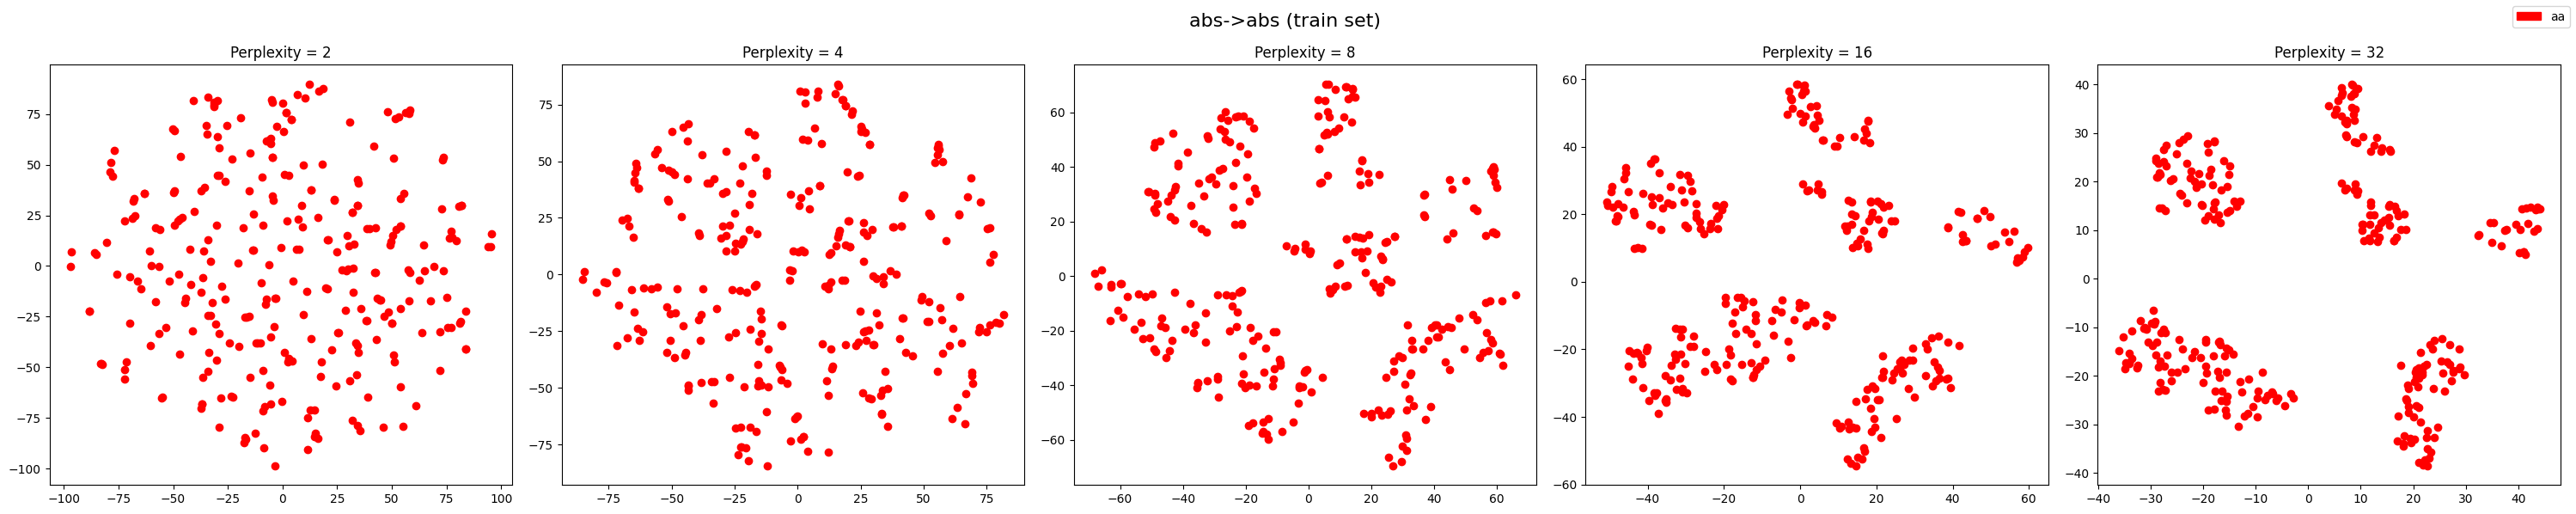

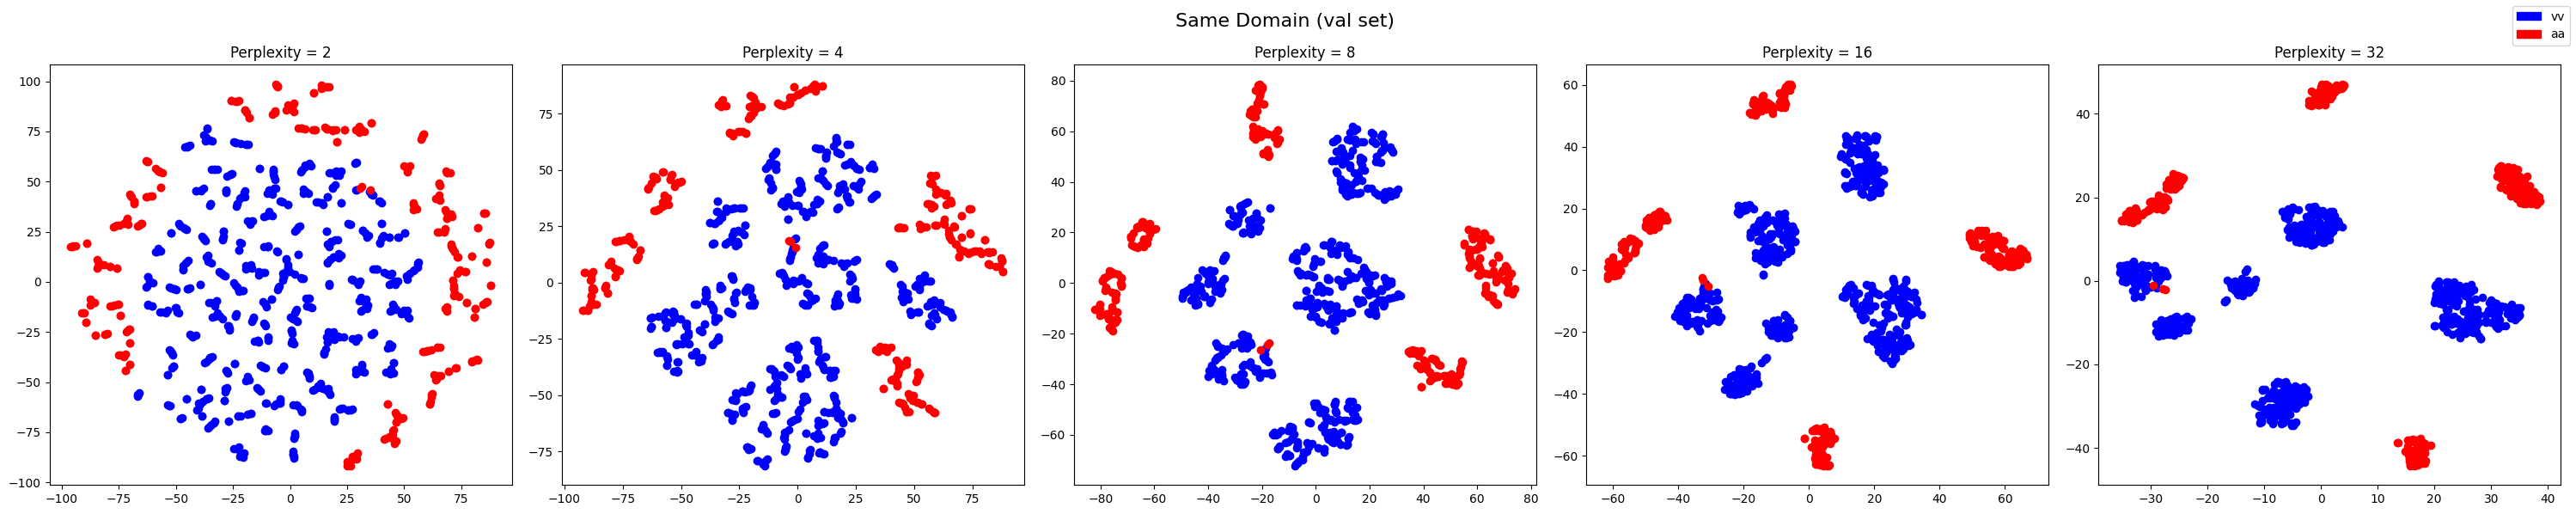

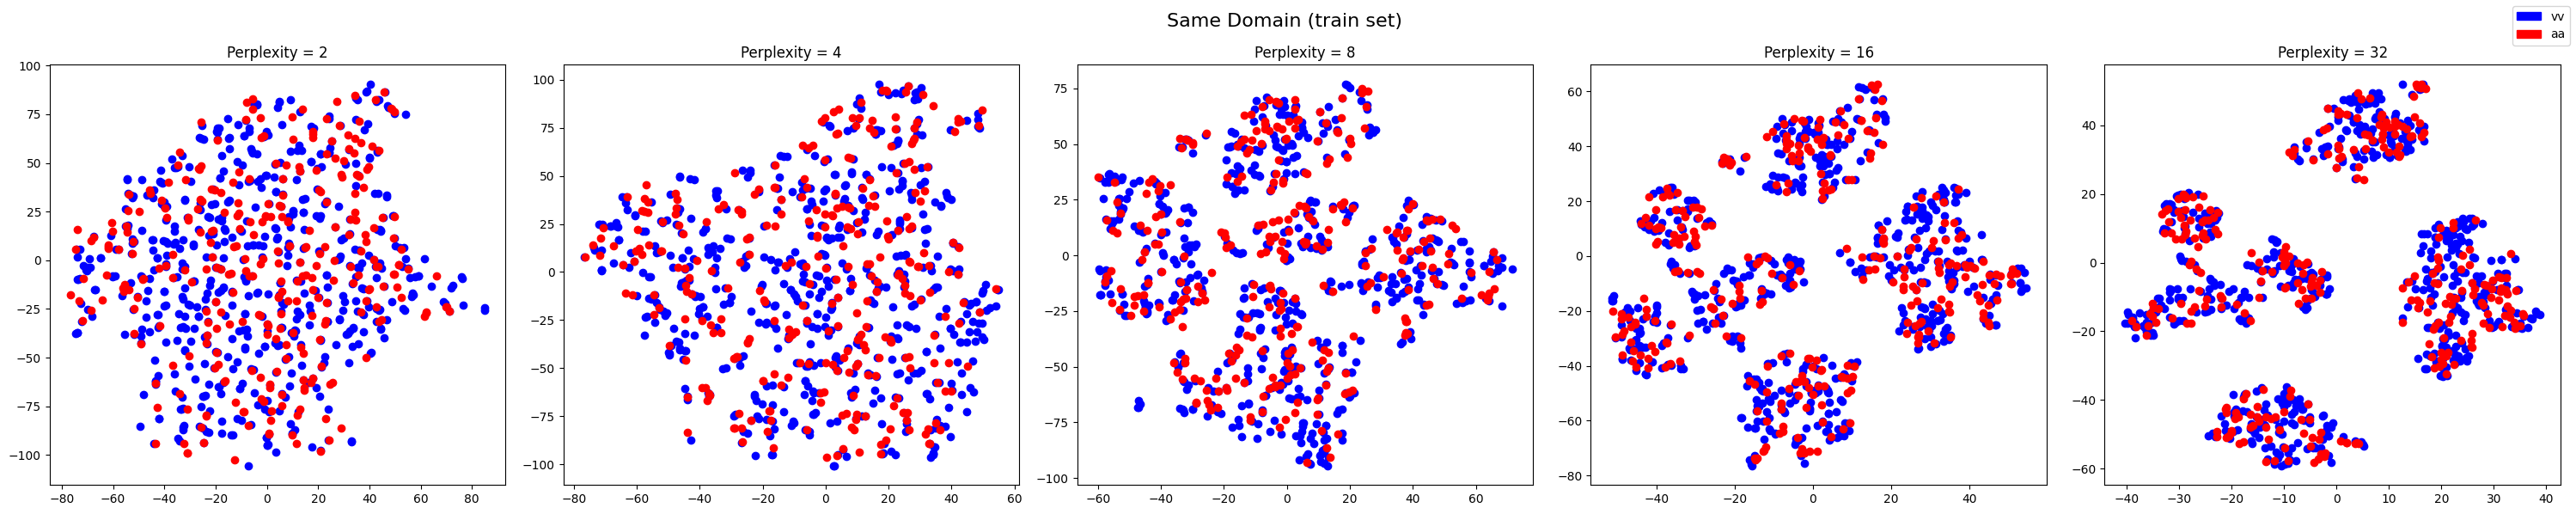

In [7]:
n_v2 = len(v2_val_embeddings)
n_abs = len(abs_val_embeddings)

# v2 -> v2
plot_tsne(v2_val_embeddings, ['vv'] * n_v2, perplexities=[2,4,8,16,32], title='v2->v2 (val set)')
plot_tsne(v2_train_embeddings, ['vv'] * n_v2, perplexities=[2,4,8,16,32], title='v2->v2 (train set)')

# abs -> abs
plot_tsne(abs_val_embeddings, ['aa'] * n_abs, perplexities=[2,4,8,16,32], title='abs->abs (val set)')
plot_tsne(abs_train_embeddings, ['aa'] * n_abs, perplexities=[2,4,8,16,32], title='abs->abs (train set)')

# combined plot
val_embeddings = np.concatenate((v2_val_embeddings, abs_val_embeddings), axis=0)
plot_tsne(val_embeddings, ['vv'] * n_v2 + ['aa'] * n_abs, perplexities=[2,4,8,16,32], title='Same Domain (val set)')

train_embeddings = np.concatenate((v2_train_embeddings, abs_train_embeddings), axis=0)
plot_tsne(train_embeddings, ['vv'] * n_v2 + ['aa'] * n_abs, perplexities=[2,4,8,16,32], title='Same Domain (train set)')

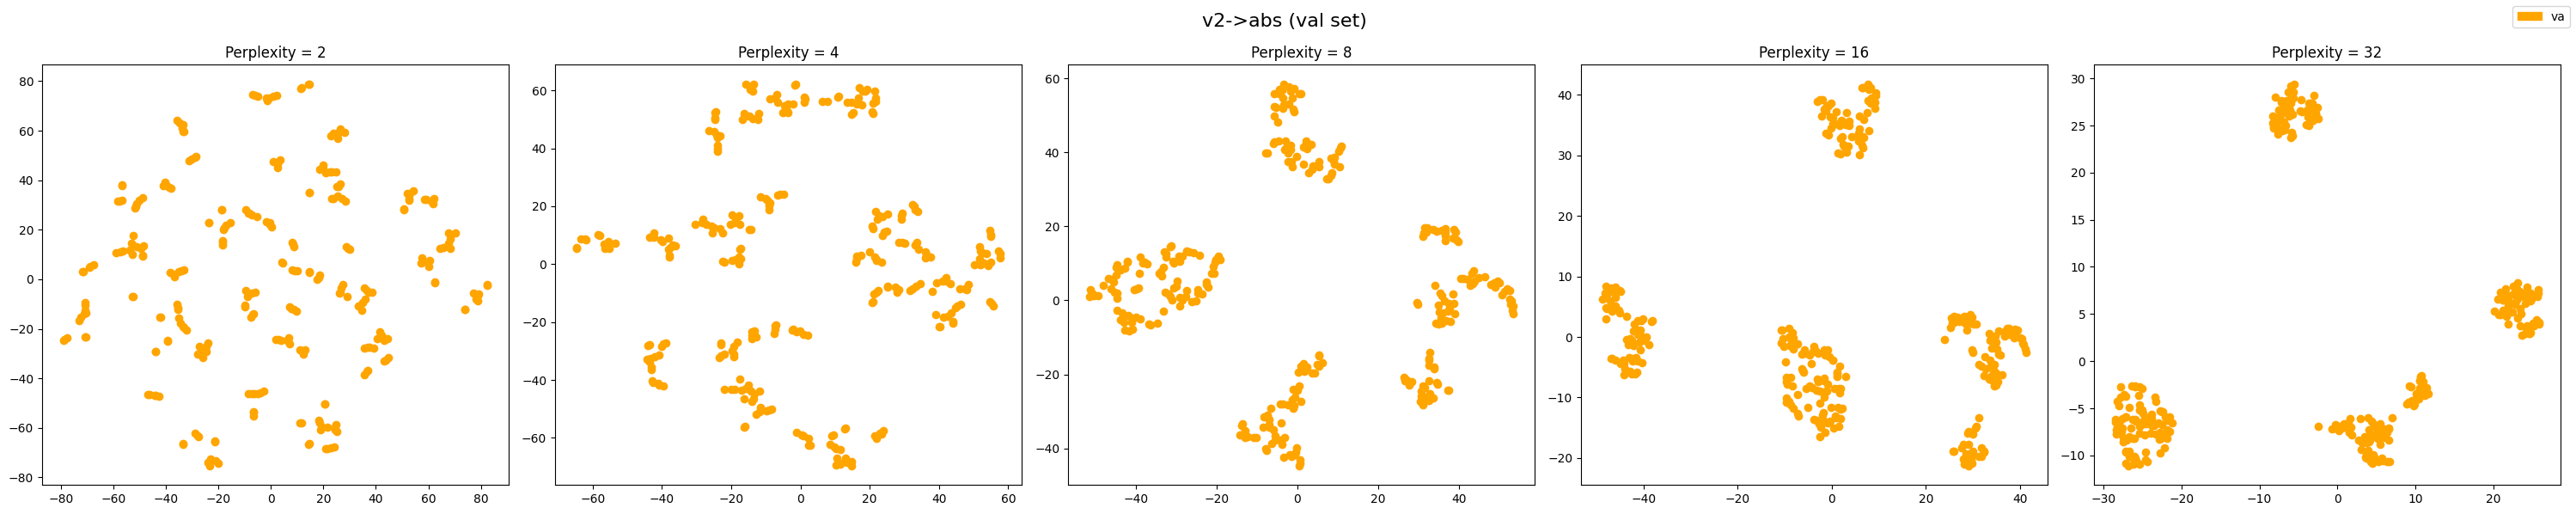

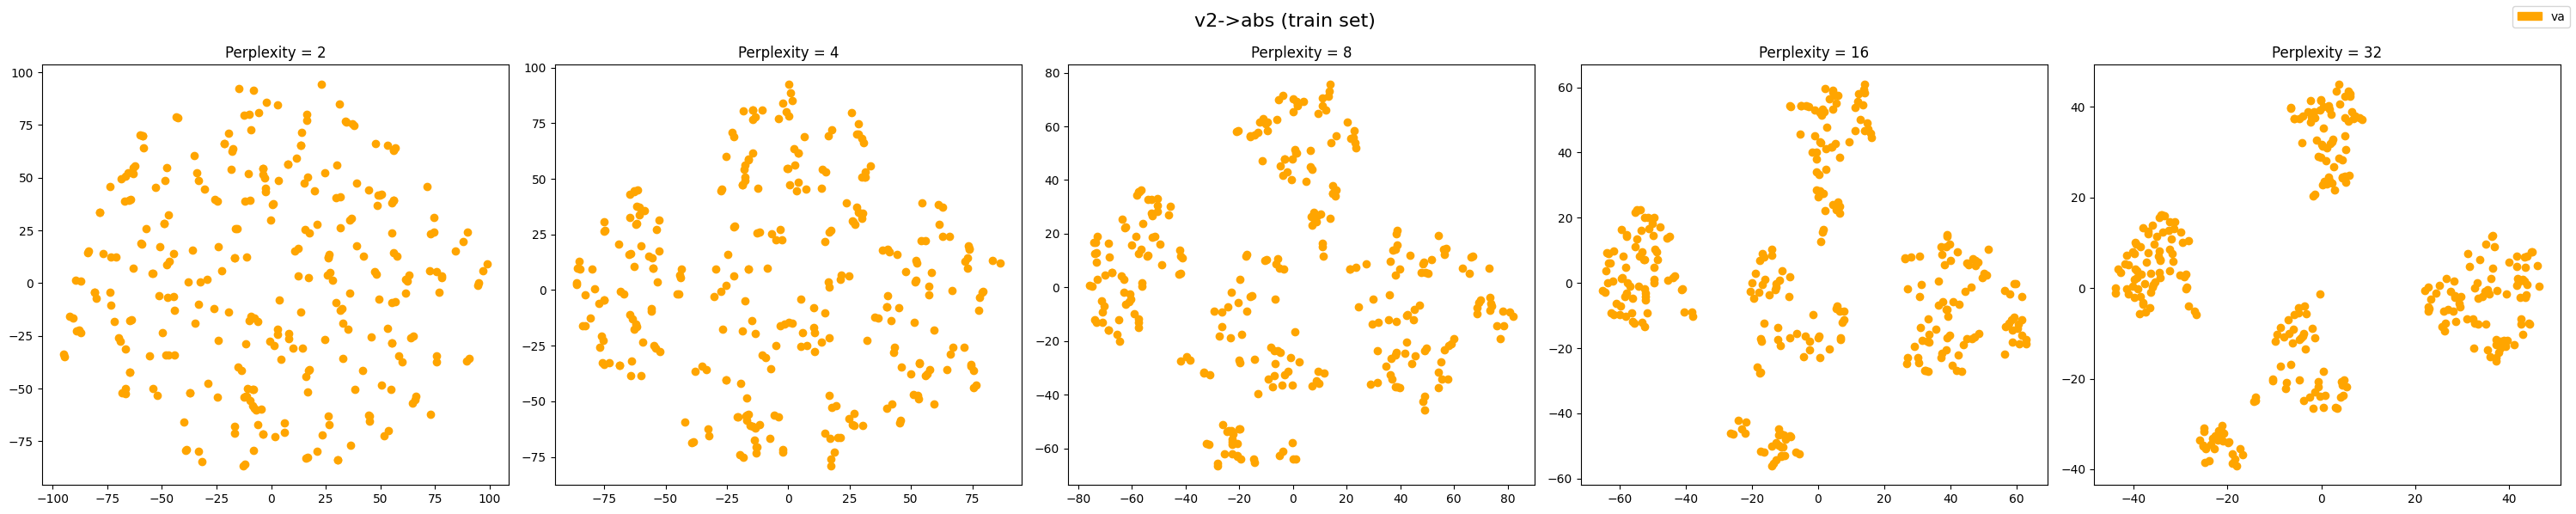

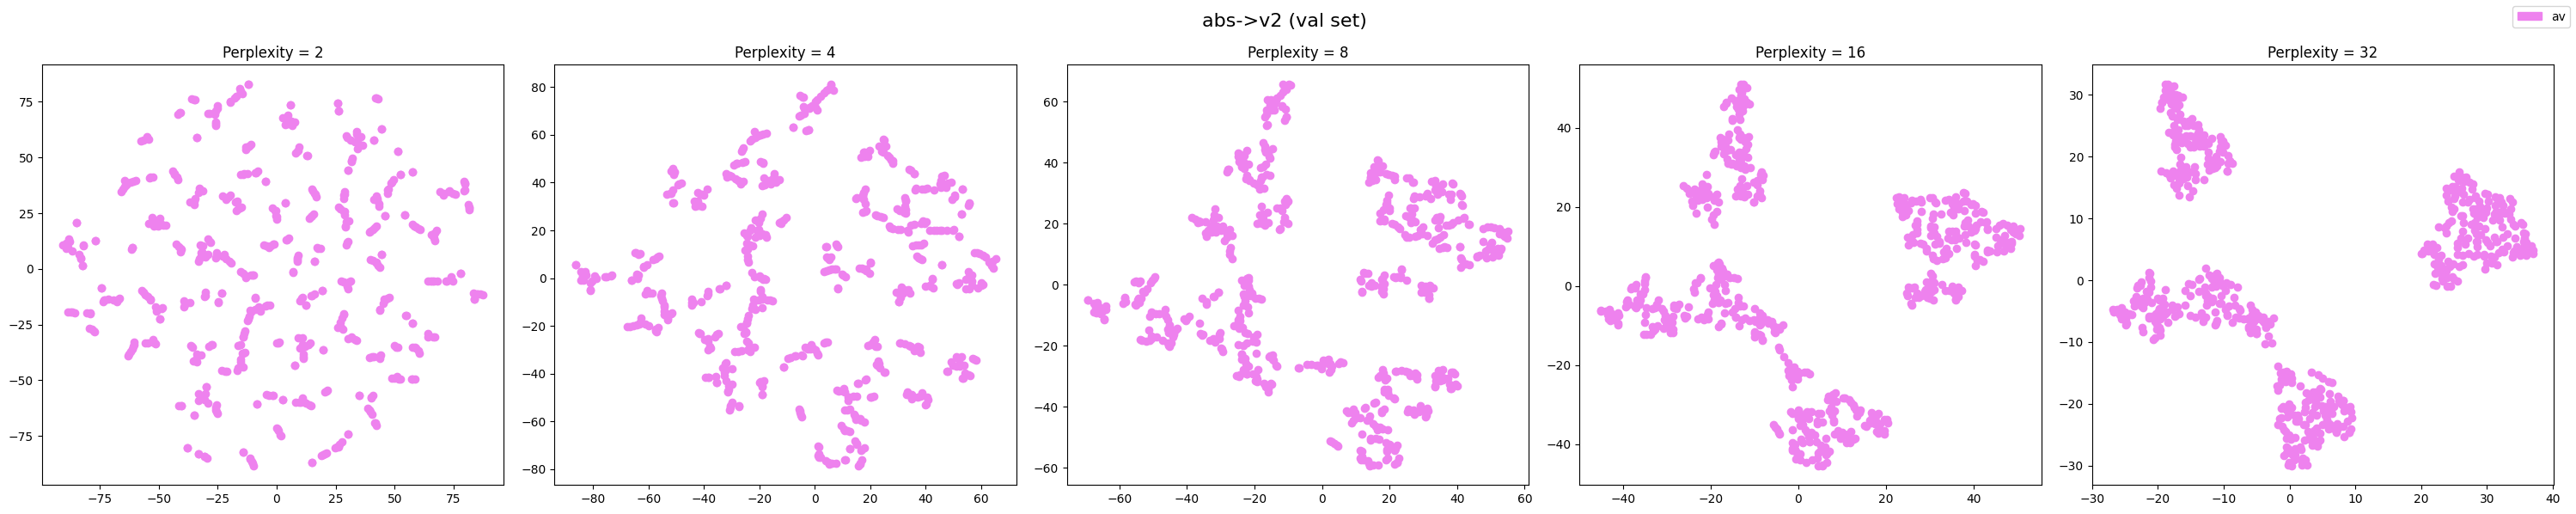

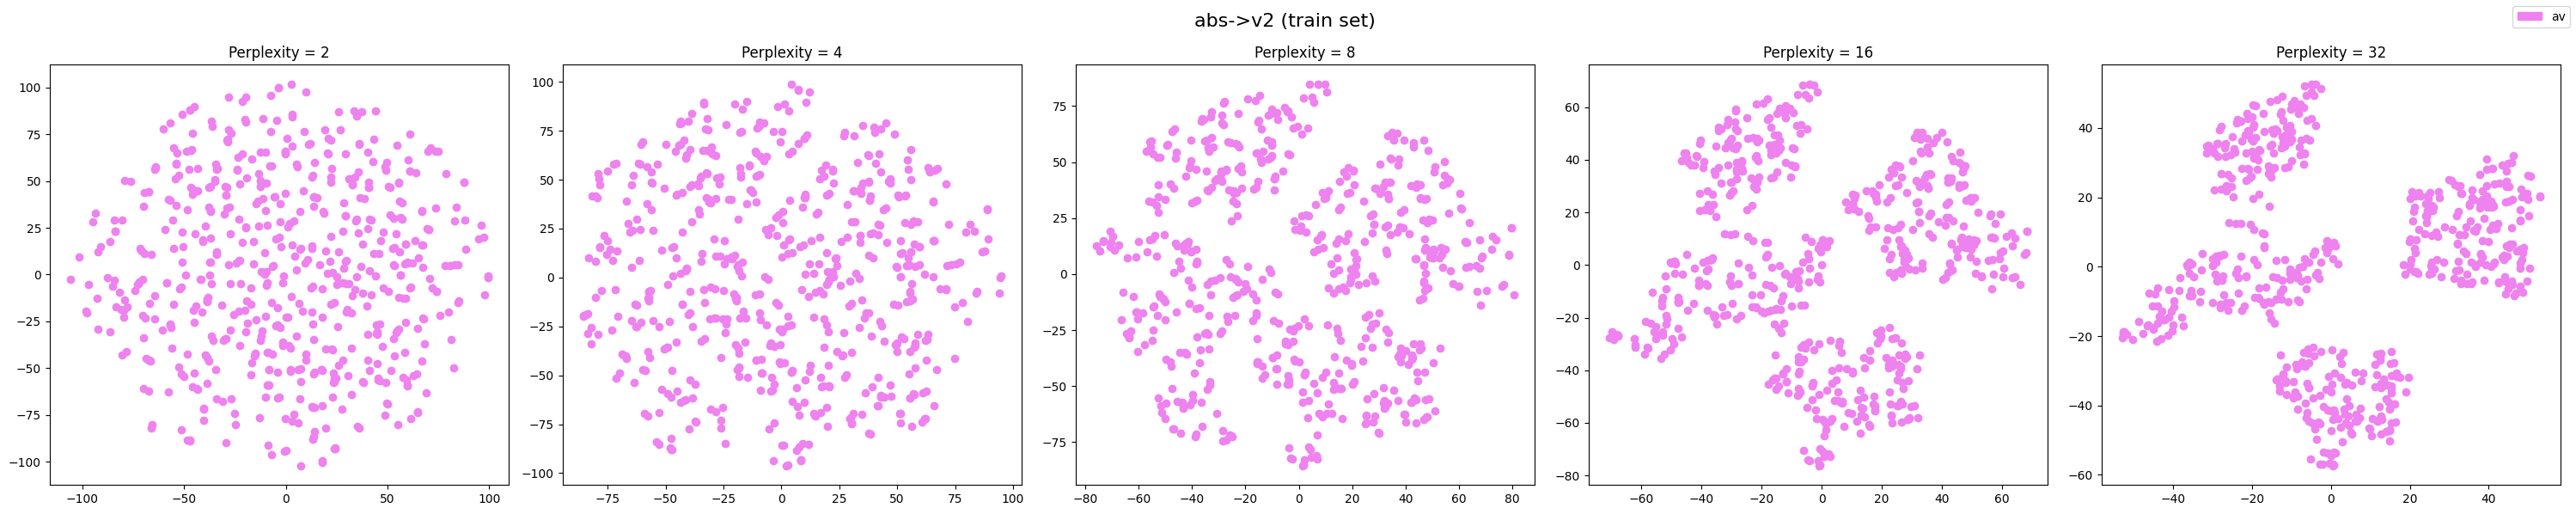

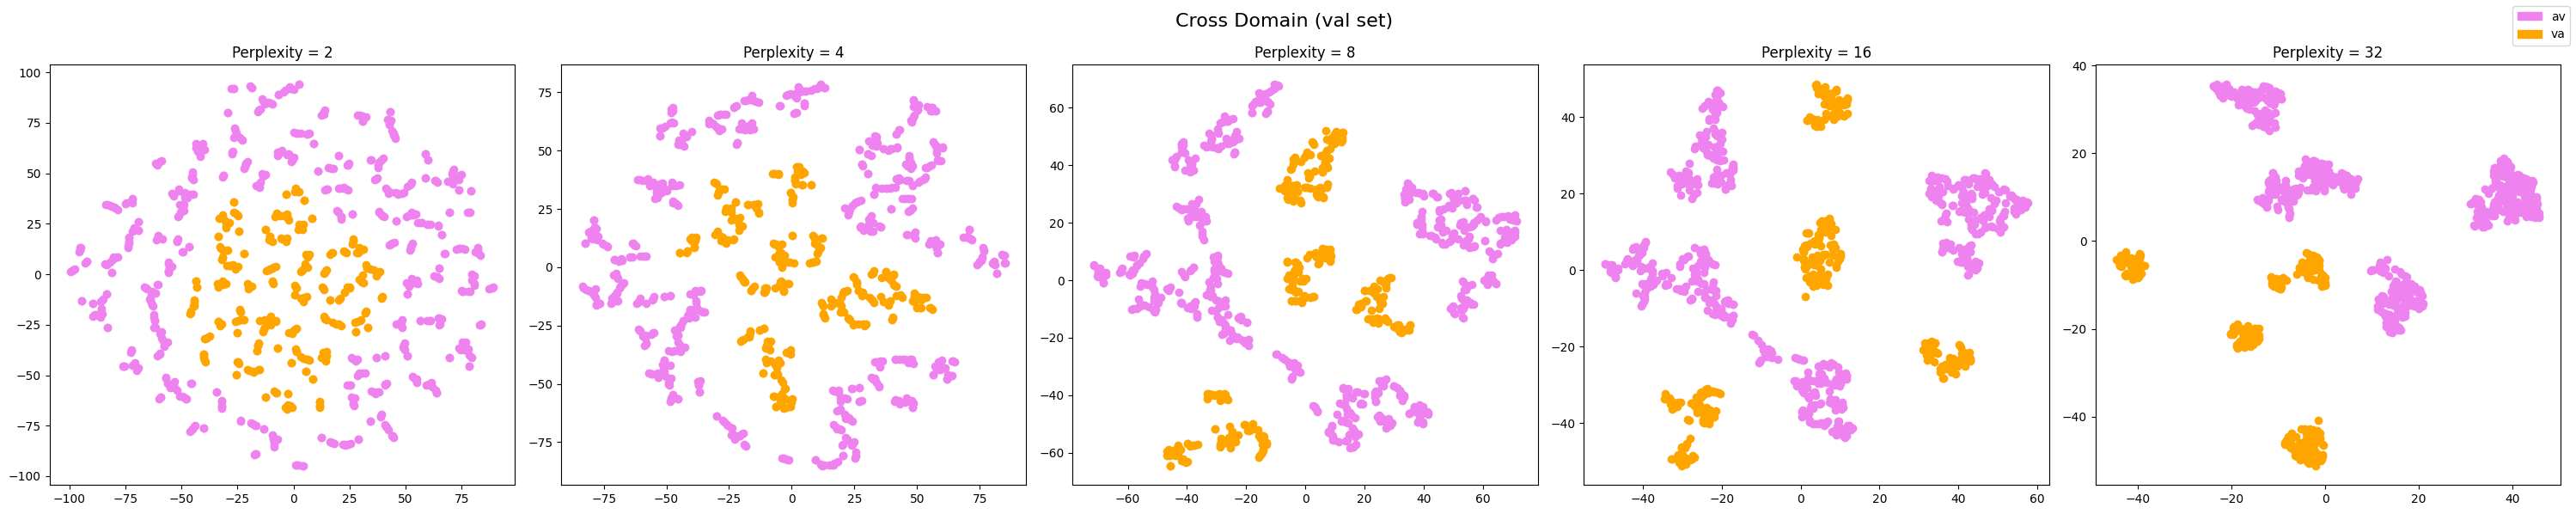

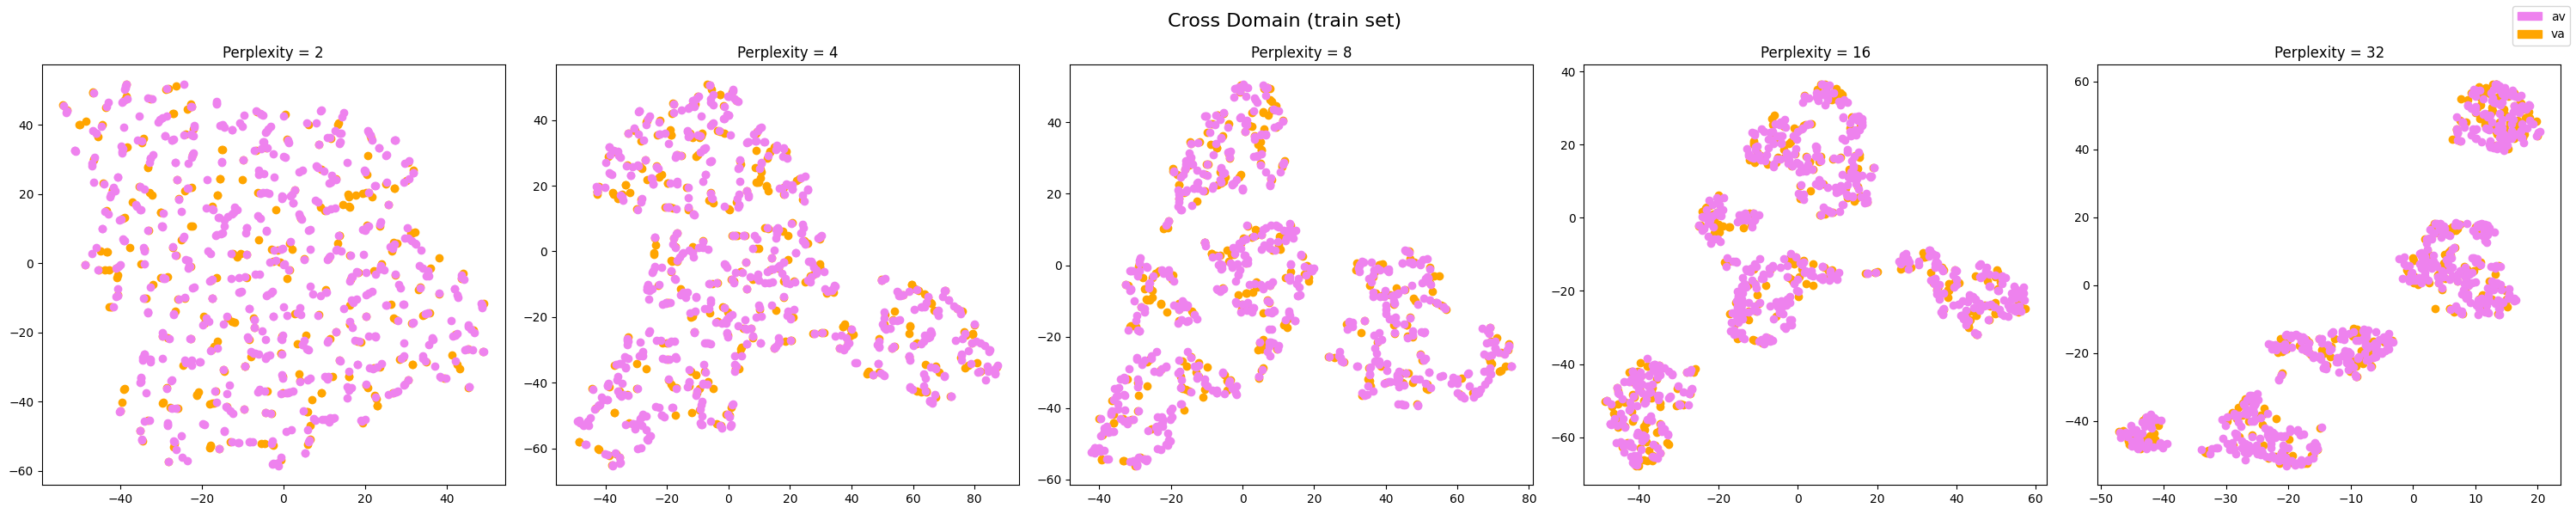

In [8]:
# v2 -> abs
plot_tsne(v2_abs_val_embeddings, ['va'] * n_abs, perplexities=[2,4,8,16,32], title='v2->abs (val set)')
plot_tsne(v2_abs_train_embeddings, ['va'] * n_abs, perplexities=[2,4,8,16,32], title='v2->abs (train set)')

# abs -> v2
plot_tsne(abs_v2_val_embeddings, ['av'] * n_v2, perplexities=[2,4,8,16,32], title='abs->v2 (val set)')
plot_tsne(abs_v2_train_embeddings, ['av'] * n_v2, perplexities=[2,4,8,16,32], title='abs->v2 (train set)')

# combined plot
val_embeddings = np.concatenate((v2_abs_val_embeddings, abs_v2_val_embeddings), axis=0)
plot_tsne(val_embeddings, ['va'] * n_abs + ['av'] * n_v2, perplexities=[2,4,8,16,32], title='Cross Domain (val set)')

train_embeddings = np.concatenate((v2_abs_train_embeddings, abs_v2_train_embeddings), axis=0)
plot_tsne(train_embeddings, ['va'] * n_abs + ['av'] * n_v2, perplexities=[2,4,8,16,32], title='Cross Domain (train set)')